# Insights into Forest Fires

## Loading libraries

In [ ]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import random

# importing sklearn libraries
from sklearn import neural_network, linear_model, preprocessing, svm, tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB

# importing keras libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

import warnings

# supressing the warning on the usage of Linear Regression model
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

## Working with the dataset

### Loading the dataset

The dataset can be downloaded from: https://www.kaggle.com/elikplim/forest-fires-data-set

The attributes in the dataset include:
1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec"
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3
7. DC - DC index from the FWI system: 7.9 to 860.6
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40
12. rain - outside rain in mm/m2 : 0.0 to 6.4
13. area - the burned area of the forest (in ha): 0.00 to 1090.84

In [ ]:
forest_fires = pd.read_csv('forest_fires.csv')
forest_fires

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


### Converting the labels under month and day to integers

In [ ]:
forest_fires.month.replace(('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'),(1,2,3,4,5,6,7,8,9,10,11,12), inplace=True)
forest_fires.day.replace(('mon','tue','wed','thu','fri','sat','sun'),(1,2,3,4,5,6,7), inplace=True)

### Statistical analysis of dataset

In [ ]:
forest_fires.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


### Corelation analysis for the dataset

In [ ]:
forest_fires.corr()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
X,1.000000,0.539548,-0.021039,-0.048384,-0.085916,0.006210,-0.051258,0.085223,0.018798,0.065387,0.063385
Y,0.539548,1.000000,-0.046308,0.007782,-0.101178,-0.024488,-0.024103,0.062221,-0.020341,0.033234,0.044873
FFMC,-0.021039,-0.046308,1.000000,0.382619,0.330512,0.531805,0.431532,-0.300995,-0.028485,0.056702,0.040122
DMC,-0.048384,0.007782,0.382619,1.000000,0.682192,0.305128,0.469594,0.073795,-0.105342,0.074790,0.072994
DC,-0.085916,-0.101178,0.330512,0.682192,1.000000,0.229154,0.496208,-0.039192,-0.203466,0.035861,0.049383
ISI,0.006210,-0.024488,0.531805,0.305128,0.229154,1.000000,0.394287,-0.132517,0.106826,0.067668,0.008258
temp,-0.051258,-0.024103,0.431532,0.469594,0.496208,0.394287,1.000000,-0.527390,-0.227116,0.069491,0.097844
RH,0.085223,0.062221,-0.300995,0.073795,-0.039192,-0.132517,-0.527390,1.000000,0.069410,0.099751,-0.075519
wind,0.018798,-0.020341,-0.028485,-0.105342,-0.203466,0.106826,-0.227116,0.069410,1.000000,0.061119,0.012317
rain,0.065387,0.033234,0.056702,0.074790,0.035861,0.067668,0.069491,0.099751,0.061119,1.000000,-0.007366


### Extracting features from the dataset

In [ ]:
x_values = list(forest_fires['X'])
y_values = list(forest_fires['Y'])

loc_values = []

for index in range(0, len(x_values)):
    temp_value = []

    temp_value.append(x_values[index])
    temp_value.append(y_values[index])
    loc_values.append(temp_value)

In [ ]:
month_values = list(forest_fires['month'])
day_values = list(forest_fires['day'])

ffmc_values = list(forest_fires['FFMC'])
dmc_values = list(forest_fires['DMC'])
dc_values = list(forest_fires['DC'])
isi_values = list(forest_fires['ISI'])

temp_values = list(forest_fires['temp'])
rh_values = list(forest_fires['RH'])
wind_values = list(forest_fires['wind'])
rain_values = list(forest_fires['rain'])

area_values = list(forest_fires['area'])

In [ ]:
attribute_list = []

for index in range(0, len(x_values)):
    temp_list = []
    
    temp_list.append(x_values[index])
    temp_list.append(y_values[index])
    
    temp_list.append(month_values[index])
    temp_list.append(day_values[index])

    temp_list.append(ffmc_values[index])
    temp_list.append(dmc_values[index])
    temp_list.append(dc_values[index])
    temp_list.append(isi_values[index])

    temp_list.append(temp_values[index])
    temp_list.append(rh_values[index])
    temp_list.append(wind_values[index])
    temp_list.append(rain_values[index])
    
    attribute_list.append(temp_list)

### Counting the instances of location points in dataset

In [ ]:
def count_points(x_points, y_points, scaling_factor):
    count_array = []
    
    for index in range(0, len(x_points)):
        temp_value = [x_points[index], y_points[index]]
        count = 0
        
        for value in loc_values:
            if(temp_value == value):
                count = count + 1
        count_array.append(count * scaling_factor )

    return count_array

### Histogram plotting function for dataset

In [ ]:
def histogram_plot(dataset, title):
    plt.figure(figsize=(8, 6))    
    
    ax = plt.subplot()    
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False)
    
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left() 
    
    plt.title(title, fontsize = 22)
    plt.hist(dataset, edgecolor='black', linewidth=1.2)

### Scatter plot for the locations

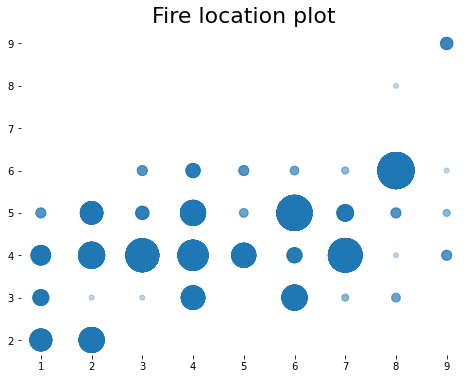

In [ ]:
plt.figure(figsize=(8, 6))    
    
ax = plt.subplot()    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)
    
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left() 
    
plt.title("Fire location plot", fontsize = 22)
plt.scatter(x_values, y_values, s = count_points(x_values, y_values, 25), alpha = 0.3)
plt.show()

### Plotting the distribution of values for the dataset

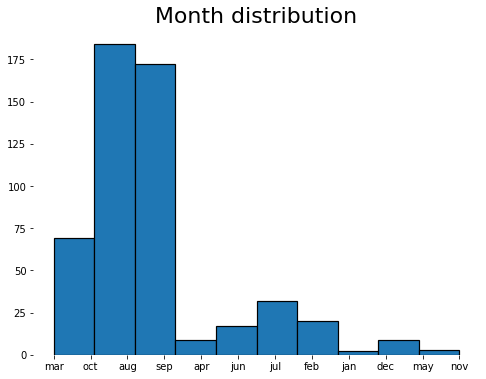

In [ ]:
histogram_plot(month_values, title = "Month distribution")
plt.show()

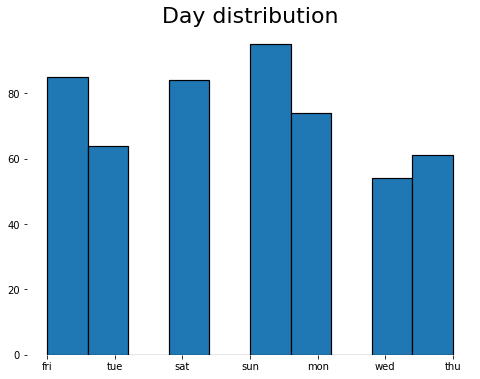

In [ ]:
histogram_plot(day_values, title = "Day distribution")
plt.show()

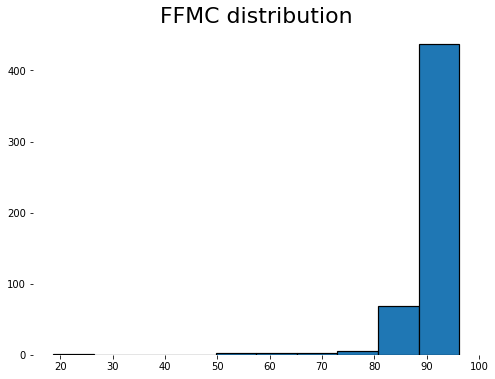

In [ ]:
histogram_plot(ffmc_values, title = "FFMC distribution")
plt.show()

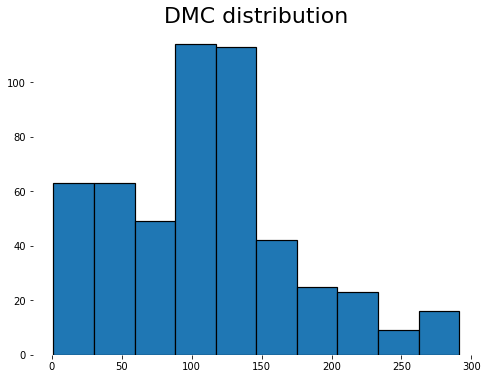

In [ ]:
histogram_plot(dmc_values, title = "DMC distribution")
plt.show()

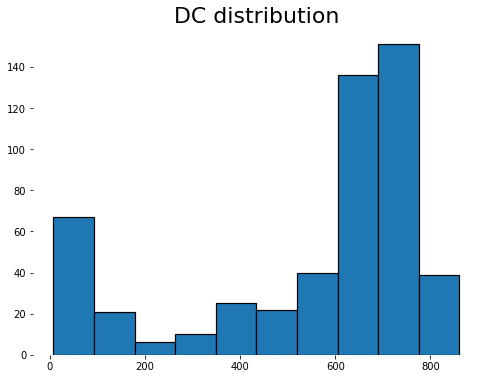

In [ ]:
histogram_plot(dc_values, title = "DC distribution")
plt.show()

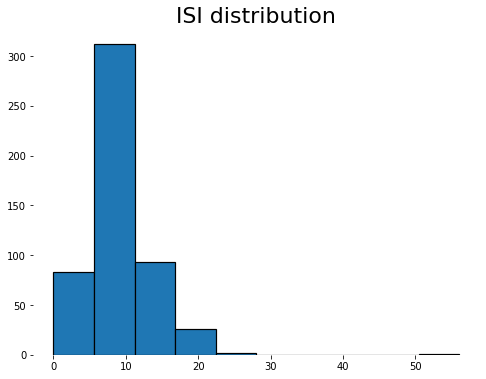

In [ ]:
histogram_plot(isi_values, title = "ISI distribution")
plt.show()

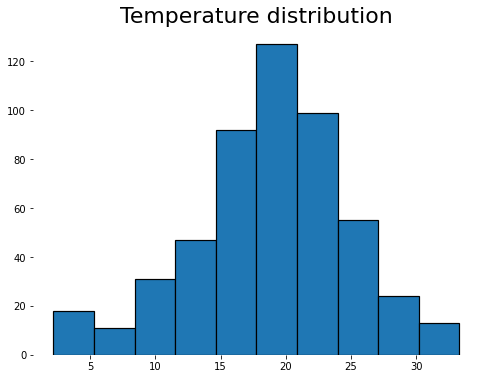

In [ ]:
histogram_plot(temp_values, title = "Temperature distribution")
plt.show()

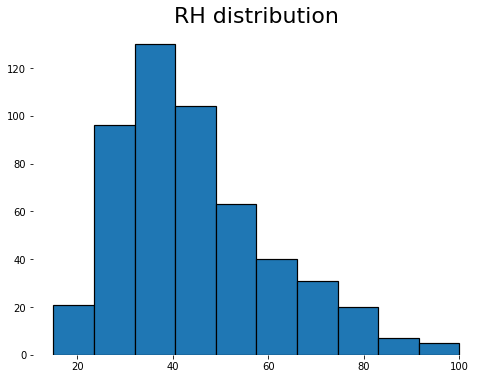

In [ ]:
histogram_plot(rh_values, title = "RH distribution")
plt.show()

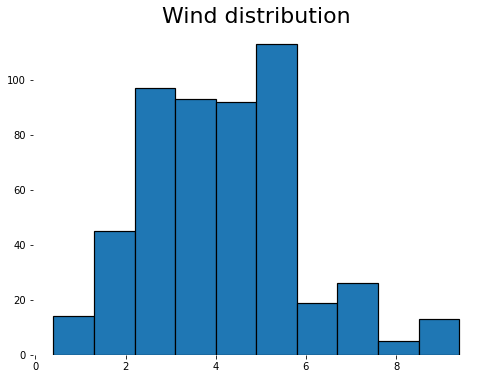

In [ ]:
histogram_plot(wind_values, title = "Wind distribution")
plt.show()

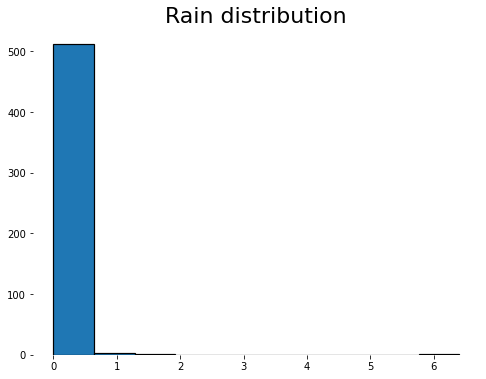

In [ ]:
histogram_plot(rain_values, title = "Rain distribution")
plt.show()

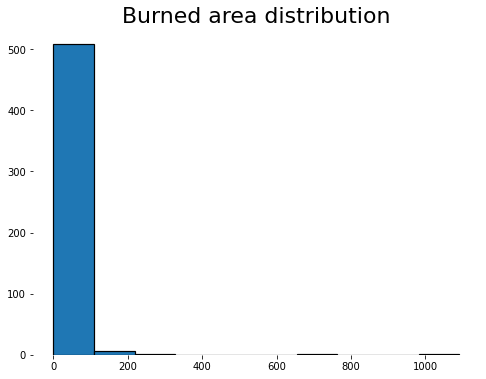

In [ ]:
histogram_plot(area_values, title = "Burned area distribution")
plt.show()

### Percentage of dataset with 'burned area' > 0

In [ ]:
total_count = 0
positive_data_count = 0

for value in area_values:
    if(value > 0):
        positive_data_count = positive_data_count + 1
    total_count = total_count + 1

print("The number of data records with 'burned area' > 0 are " + str(positive_data_count) + " and the total number of records are " + str(total_count) + ".")
print("The percentage value is " + str(positive_data_count/total_count * 100) + ".")

The number of data records with 'burned area' > 0 are 270 and the total number of records are 517.
The percentage value is 52.22437137330754.


## Gaining insights with learning models

### Spilliting the available data/Setting the initial parameters

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(attribute_list, area_values, test_size=0.3, random_state = 9)
mse_values = []
variance_score = []

### Printing the actual vs predicted values

In [ ]:
def print_values(test, predicted):
    print("The actual output and the predicted output are:")
    
    for value in range(0, len(predicted_y)):
        print('%.4f' % test_y[value], " ", '%.4f' % predicted_y[value])

### Linear regression model

In [ ]:
linear_regression = linear_model.LinearRegression()

linear_regression.fit(train_x, train_y)
predicted_y = linear_regression.predict(test_x)

print('Coefficients: \n', linear_regression.coef_)

print("\nMean squared error: ", mean_squared_error(test_y, predicted_y))
print('Variance score: %.2f' % r2_score(test_y, predicted_y))

mse_values.append(mean_squared_error(test_y, predicted_y))
variance_score.append(r2_score(test_y, predicted_y))

#print_values(test_y, predicted_y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:968: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  estimator=estimator,


ValueError: ignored

### Bayesian ridge model

In [ ]:
bayesian_ridge = linear_model.BayesianRidge()
bayesian_ridge.fit(train_x, train_y)
predicted_y = bayesian_ridge.predict(test_x)

print("Mean squared error: ", mean_squared_error(test_y, predicted_y))
print('Variance score: %.2f' % r2_score(test_y, predicted_y))

mse_values.append(mean_squared_error(test_y, predicted_y))
variance_score.append(r2_score(test_y, predicted_y))

#print_values(test_y, predicted_y)

ValueError: ignored

### Lasso model

In [ ]:
lasso_model = linear_model.Lasso()
lasso_model.fit(train_x, train_y)
predicted_y = lasso_model.predict(test_x)

print("Mean squared error: ", mean_squared_error(test_y, predicted_y))
print('Variance score: %.2f' % r2_score(test_y, predicted_y))

mse_values.append(mean_squared_error(test_y, predicted_y))
variance_score.append(r2_score(test_y, predicted_y))

#print_values(test_y, predicted_y)

ValueError: ignored

### Function for generating the graph

In [ ]:
def generate_plot(title, ticks, dataset, color_number):
    colors = ["slateblue", "mediumseagreen", "tomato"]
    plt.figure(figsize=(8, 6))
    
    ax = plt.subplot()    
    ax.spines["top"].set_visible(False)   
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left() 
    
    plt.xticks(np.arange(len(ticks)), ticks, fontsize=10, rotation=30)
    plt.title(title, fontsize = 22)
    plt.bar(ticks, dataset, linewidth=1.2, color=colors[color_number])

### Mean squared error graph

ValueError: ignored

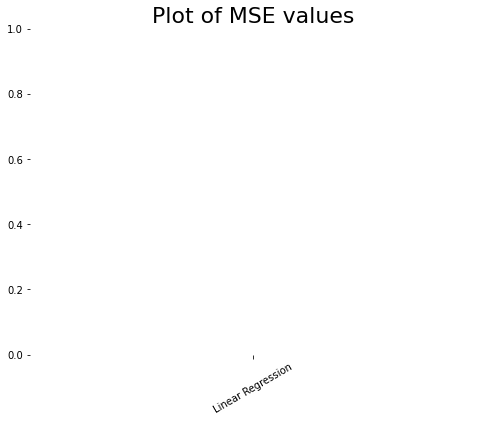

In [ ]:
ticks = ["Linear Regression", "Bayesion Ridge", "Lasso"]
generate_plot("Plot of MSE values", ticks, mse_values, 0)

### Variance score graph

ValueError: ignored

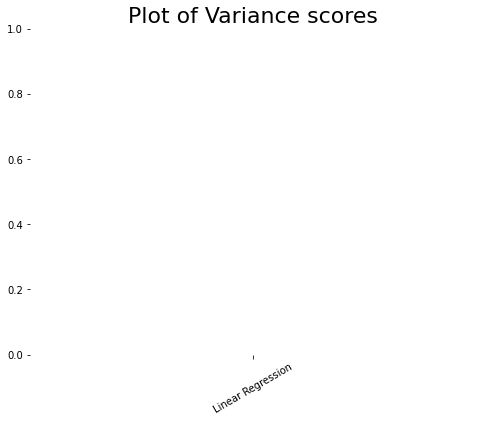

In [ ]:
generate_plot("Plot of Variance scores", ticks, variance_score, 1)

## Applying Log-Transformation to the 'burned area' variable

We can see that the errors in the prediction of burned areas from the given dataset is very high in the above mentioned model. A reason for this could be the high skewness of the 'Burned Area' variable is towards zero.

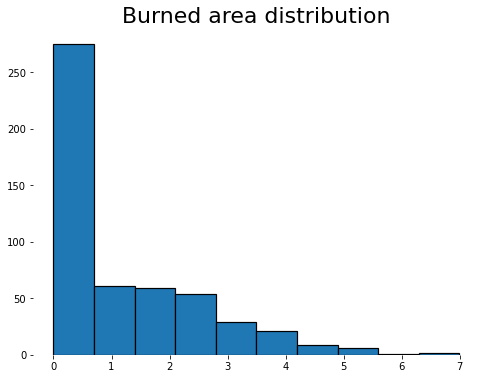

In [ ]:
area_values = list(np.log(np.array(area_values) + 1))
histogram_plot(area_values, title = "Burned area distribution")

## Applying learning models on the processed data

### Setting the initial parameters

In [ ]:
mse_values = []
variance_score = []

### Linear regression model

In [ ]:
linear_regression = linear_model.LinearRegression()

linear_regression.fit(train_x, train_y)
predicted_y = linear_regression.predict(test_x)

print('Coefficients: \n', linear_regression.coef_)

print("\nMean squared error: ", mean_squared_error(test_y, predicted_y))
print('Variance score: %.2f' % r2_score(test_y, predicted_y))

mse_values.append(mean_squared_error(test_y, predicted_y))
variance_score.append(r2_score(test_y, predicted_y))

#print_values(test_y, predicted_y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:968: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  estimator=estimator,


ValueError: ignored

### Bayesian ridge model

In [ ]:
bayesian_ridge = linear_model.BayesianRidge()
bayesian_ridge.fit(train_x, train_y)
predicted_y = bayesian_ridge.predict(test_x)

print("Mean squared error: ", mean_squared_error(test_y, predicted_y))
print('Variance score: %.2f' % r2_score(test_y, predicted_y))

mse_values.append(mean_squared_error(test_y, predicted_y))
variance_score.append(r2_score(test_y, predicted_y))

#print_values(test_y, predicted_y)

ValueError: ignored

### Lasso model

In [ ]:
lasso_model = linear_model.Lasso()
lasso_model.fit(train_x, train_y)
predicted_y = lasso_model.predict(test_x)

print("Mean squared error: ", mean_squared_error(test_y, predicted_y))
print('Variance score: %.2f' % r2_score(test_y, predicted_y))

mse_values.append(mean_squared_error(test_y, predicted_y))
variance_score.append(r2_score(test_y, predicted_y))

#print_values(test_y, predicted_y)

ValueError: ignored

### Mean squared error graph

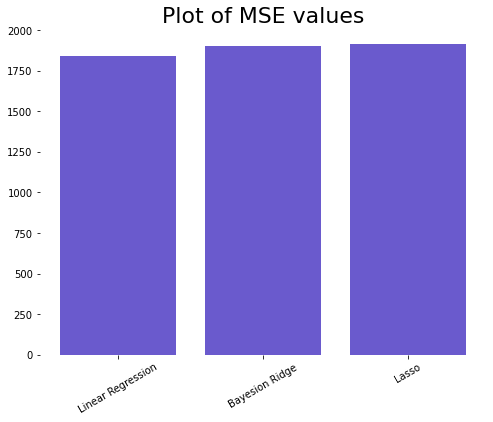

In [ ]:
ticks = ["Linear Regression",  "Bayesion Ridge", "Lasso"]
generate_plot("Plot of MSE values", ticks, mse_values, 0)

### Variance score graph

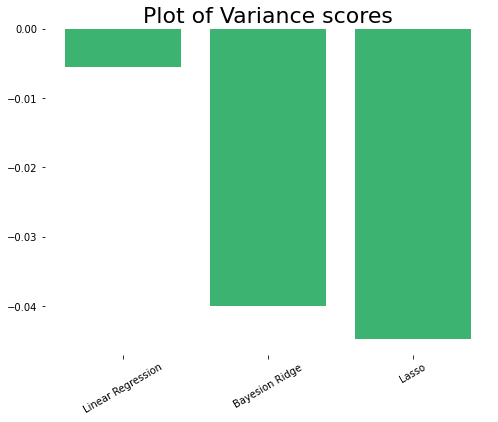

In [ ]:
generate_plot("Plot of Variance scores", ticks, variance_score, 1)

## Normalisation of all data

In [ ]:
n_x_values = preprocessing.normalize([x_values])[0]
n_y_values = preprocessing.normalize([y_values])[0]

n_month_values = preprocessing.normalize([month_values])[0]
n_day_values = preprocessing.normalize([day_values])[0]

n_ffmc_values = preprocessing.normalize([ffmc_values])[0]
n_dmc_values = preprocessing.normalize([dmc_values])[0]
n_dc_values = preprocessing.normalize([dc_values])[0]
n_isi_values = preprocessing.normalize([isi_values])[0]

n_temp_values = preprocessing.normalize([temp_values])[0]
n_rh_values = preprocessing.normalize([rh_values])[0]
n_wind_values = preprocessing.normalize([wind_values])[0]
n_rain_values = preprocessing.normalize([rain_values])[0]

n_area_values = preprocessing.normalize([area_values])[0]
n_attribute_list = []

for index in range(0, len(n_x_values)):
    temp_list = []
    
    temp_list.append(n_x_values[index])
    temp_list.append(n_y_values[index])
    
    temp_list.append(n_month_values[index])
    temp_list.append(n_day_values[index])

    temp_list.append(n_ffmc_values[index])
    temp_list.append(n_dmc_values[index])
    temp_list.append(n_dc_values[index])
    temp_list.append(n_isi_values[index])

    temp_list.append(n_temp_values[index])
    temp_list.append(n_rh_values[index])
    temp_list.append(n_wind_values[index])
    temp_list.append(n_rain_values[index])
    
    n_attribute_list.append(temp_list)

## Applying learning models on the normalised data

### Setting the initial parameters

In [ ]:
mse_values = []
variance_score = []

### Spilliting the available data

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(n_attribute_list, n_area_values, test_size=0.3, random_state = 9)

### Linear regression model

In [ ]:
linear_regression = linear_model.LinearRegression()

linear_regression.fit(train_x, train_y)
predicted_y = linear_regression.predict(test_x)

print('Coefficients: \n', linear_regression.coef_)

print("\nMean squared error: ", mean_squared_error(test_y, predicted_y))
print('Variance score: %.2f' % r2_score(test_y, predicted_y))

mse_values.append(mean_squared_error(test_y, predicted_y))
variance_score.append(r2_score(test_y, predicted_y))

#print_values(test_y, predicted_y)

Coefficients: 
 [ 0.06062002  0.11191486  0.34063326  0.04497625  0.08314295  0.11997013
 -0.13438317 -0.12264177 -0.08720562 -0.30440979  0.16393813  0.02727977]

Mean squared error:  0.0014262234988405913
Variance score: 0.00


### Bayesian ridge model

In [ ]:
bayesian_ridge = linear_model.BayesianRidge()
bayesian_ridge.fit(train_x, train_y)
predicted_y = bayesian_ridge.predict(test_x)

print("Mean squared error: ", mean_squared_error(test_y, predicted_y))
print('Variance score: %.2f' % r2_score(test_y, predicted_y))

mse_values.append(mean_squared_error(test_y, predicted_y))
variance_score.append(r2_score(test_y, predicted_y))

#print_values(test_y, predicted_y)

Mean squared error:  0.0014433272248326264
Variance score: -0.01


### Lasso model

In [ ]:
lasso_model = linear_model.Lasso()
lasso_model.fit(train_x, train_y)
predicted_y = lasso_model.predict(test_x)

print("Mean squared error: ", mean_squared_error(test_y, predicted_y))
print('Variance score: %.2f' % r2_score(test_y, predicted_y))

mse_values.append(mean_squared_error(test_y, predicted_y))
variance_score.append(r2_score(test_y, predicted_y))

#print_values(test_y, predicted_y)

Mean squared error:  0.0014437638154593492
Variance score: -0.01


## Visualising the results

### Mean squared error graph

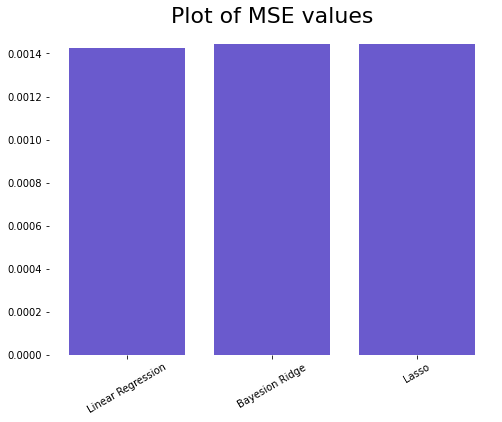

In [ ]:
ticks = ["Linear Regression", "Bayesion Ridge", "Lasso"]
generate_plot("Plot of MSE values", ticks, mse_values, 0)

### Variance score graph

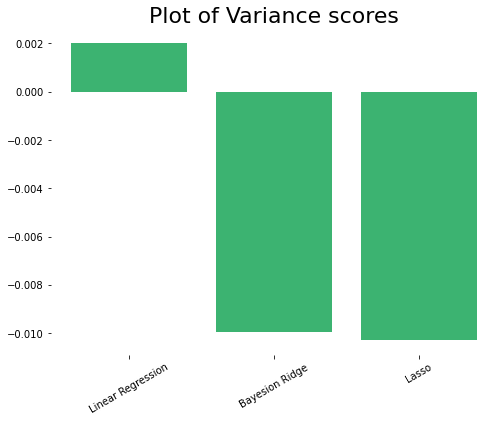

In [ ]:
generate_plot("Plot of Variance scores", ticks, variance_score, 1)

The next step is to try out binary classification for this problem.